In [5]:
import math
import pickle
import string
import fnmatch
import os
import sys
from collections import Counter

import tldextract
import numpy as np
from scipy.stats import describe
from tqdm import tqdm_notebook
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.externals import joblib
import pandas as pd
import seaborn
import matplotlib.pyplot as plt

## Utils
def rwalk(directory, pattern):
    """Recursively search "directory" for files that match the Unix shell-style
        wildcard given by "pattern" (like '*.mp3'). Returns matches as a generator."""
    for root, dirnames, filenames in os.walk(directory):
        for filename in fnmatch.filter(filenames, pattern):
            yield os.path.join(root, filename)

def chunks(l, n, slide=None):
    """Yield successive n-sized chunks from l with a sliding window of slide
    indexes. Default value of slide has non-overlapping chunks."""
    if slide is None: slide = n
    for i in range(0, len(l), slide):
        yield l[i:i+n]

def H(s):
    p, lns = Counter(s), float(len(s))
    return -sum(count/lns * math.log(count/lns, 2) for count in p.values())

## Classification stuff
def _load_ground_truth(dgadir='../data/dga/ground-truth'):
    def fixup(d):
        return d.lower().strip()
    classtodomains = {}
    for path in rwalk(dgadir, '*.txt'):
        with open(path) as f:
            class_ = os.path.basename(os.path.dirname(path))
            classtodomains[class_] = list(map(fixup, f.readlines()))

    return classtodomains

def _ngrams(domains, ns=[1, 2, 3, 4]):
    def stats(counter, n):
        # you can use the below to see this w.r.t. all possibilities.
        #possibilities = len(string.ascii_lowercase + string.digits + '-.')**n
        l = list(counter.values())
        res = describe(l)
        median = np.median(l)

        return [res.mean, median, math.sqrt(res.variance)]

    features = []
    for n in ns:
        for domain in domains:
            domain = domain.lower()
            c = Counter([chunk for chunk in chunks(domain, n, slide=1) if len(chunk) == n])
            features.extend(stats(c, n))

    return features

def _e2and3ld_entropy(domain):
    def onlylast(domain):
        return domain.split('.')[-1]
    domain = domain.lower()
    res = tldextract.extract(domain)
    e2ld = '%s.%s' % (res.domain, res.suffix)
    if res.subdomain:
        e3ld = '%s.%s.%s' % (onlylast(res.subdomain),
                             res.domain,
                             res.suffix)
    else:
        e3ld = e2ld

    return H(e2ld), H(e3ld)

def _entropy(domains):
    perdomain = {domain: _e2and3ld_entropy(domain) for domain in domains}
    e2ld_h = [x[0] for x in perdomain.values()]
    e3ld_h = [x[1] for x in perdomain.values()]

    return (perdomain, [describe(e2ld_h).mean, np.median(e2ld_h),
                        describe(e3ld_h).mean, np.median(e3ld_h)])

def _len(domains):
    lengths = list(map(len, domains))
    res = describe(lengths)
    return [res.mean, np.median(lengths), math.sqrt(res.variance), res.variance]

def _levels(domains):
    def numlevels(d):
        return len(list(filter(lambda x: x == '.', d))) + 1
    numlds = [numlevels(d) for d in domains]
    res = describe(numlds)
    return [res.mean, np.median(numlds), math.sqrt(res.variance), res.variance]

def _tlds(domains):
    return len(Counter([x.split('.')[-1] for x in domains]))

def _distinctchars(domains):
    return len(Counter(''.join(domains)))

def vectorize(domains):
    features = []
    features.extend(_ngrams(domains))
    features.extend(_entropy(domains)[1])
    features.extend(_len(domains))
    features.extend(_levels(domains))
    features.append(_tlds(domains))
    features.append(_distinctchars(domains))
    return features

def _build_ground_truth_dataframe(alpha=10, dgadir='../data/dga/ground-truth'):
    X, y = [], []
    for class_, domains in tqdm_notebook(_load_ground_truth(dgadir=dgadir).items(), desc='Classes', position=0):
        if class_ in set(['murofet', 'suppobox', 'symmi', 'sisron', 'ranbyus', 'corebot', 'padcrypt', 'dircrypt', 'gozi', 'locky', 'pykspa', 'dnschanger']):
            continue
        for domain_chunks in chunks(domains, alpha):
            features = vectorize(domain_chunks)
            if len(features) != 134:
                #sys.stderr.write('Error with chunk from %s\n' % class_)
                continue
            X.append(features)
            y.append(class_)

    return np.array(X), np.array(y)

def _heatmap(crosstab):
    plt.clf()
    p = seaborn.heatmap(crosstab, square=True)
    plt.tight_layout()
    plt.show()

def _cv(X, y, k, name, clf, csvname, modeldir=None, terms=None, resultdir=None):
    print('## %s' % name)
    print('### Cross Validation')
    print('`%s`' % str(cross_val_score(clf, X, y, cv=k)))
    print('### CV Confusion Matrix')
    y_pred = cross_val_predict(clf, X, y, cv=k)
    print('```')
    print(pd.crosstab(y, y_pred, rownames=['True'], colnames=['Predicted']))
    print('```')

    _heatmap(pd.crosstab(y, y_pred, rownames=['True'], colnames=['Predicted'],
                         normalize='index'))

    clf.fit(X, y)
    return clf

def train():
    pass

# * Generate feature vector from set of domains
# ** Important to note that it needs to chunk em up for the classifier to work. Refer to Pleiades paper.
# ** Chunks into groups of alpha = 10
# ** 1,2,3,4-gram. get mean, median, std. dev. (4 x 3 = 12 features)
# ** shannon entropy of 2ld/3ld. exact value per domain (2x), mean/median of group (2 x 2) total of 6 features.
# ** mean, med, std. dev, var of length, # of domain levels, distinct chars, # distinct TLDs, # .com, # .other, ratio of #.com/#.other, mean/med/stddev TLDs
# * Train model
# * Fit cluster
# * Output as JSON maybe huh

def save(obj, path):
    with open(path, 'wb') as f:
        pickle.dump(obj, f)

def load(path):
    with open(path, 'rb') as f:
        return pickle.load(f)

/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



## DGA Classifier
### Cross Validation


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/opt/conda

`[ 0.99447514  0.99447514  0.98895028  0.99447514  1.          0.99438202
  0.97752809  0.98314607  1.          0.98314607]`
### CV Confusion Matrix


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/opt/conda

```
Predicted    banjori  chinad  fobber  kraken  necurs  newgoz  nymaim2  \
True                                                                    
banjori          100       0       0       0       0       0        0   
chinad             0      25       0       0       0       0        0   
fobber             0       0      30       0       0       0        0   
kraken             0       0       0     198       0       0        0   
necurs             0       0       0       1     199       0        2   
newgoz             0       0       0       0       0     100        0   
nymaim2            0       0       0       0       6       0       64   
proslikefan        0       0       0       0       0       0        0   
qadars             0       0       0       0       0       0        0   
qakbot             0       0       0       0       0       0        0   
ramnit             0       0       0       0       0       0        0   
shiotob            0       0       0       0   

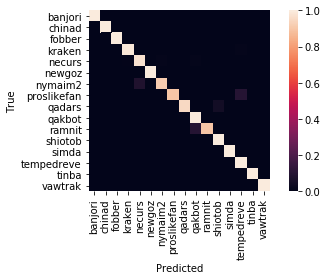

In [ ]:
X, y = _build_ground_truth_dataframe()
_cv(X, y, 10, 'DGA Classifier', LogisticRegression(solver='lbfgs', max_iter=1000, multi_class='auto'), 'dga-classifier.csv')